# SVM Model

In [1]:
# Uncomment to get the correct versions
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output() 


In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



In [3]:
# Get the data

x_train_path = '../../data/train_test_split/x_train_cluster.csv'
y_train_path = '../../data/train_test_split/y_train.csv'

x_test_path = '../../data/train_test_split/x_test_cluster.csv'
y_test_path = '../../data/train_test_split/y_test.csv'

x_train_df = pd.read_csv(x_train_path) 
y_train_df = pd.read_csv(y_train_path) 

x_test_df = pd.read_csv(x_test_path)
y_test_df = pd.read_csv(y_test_path)



In [4]:
# Combine train and test
train_df = pd.merge(x_train_df, y_train_df, how='left', left_index=True, right_index=True)
test_df = pd.merge(x_test_df, y_test_df,how='left', left_index=True, right_index=True)

In [5]:
test_df.columns

Index(['name', 'rating', 'ranking', 'year', 'position', 'height', 'weight',
       'latitude', 'longitude', 'hometown_city', 'state_province',
       'hometown_country', 'stars', 'committed_to', 'athlete_id', 'conference',
       'latitude_school', 'longitude_school', 'wins_rolling_2year',
       'games_played_rolling_2year', 'post_season_wins_rolling_2year',
       'point_diff_rolling_2year', 'win_pct_rolling_2year', 'distance_miles',
       'side_of_ball', 'position_group', 'SVD_KMeans_Cluster',
       'KMeans_Cluster', 'Unnamed: 0', 'is_drafted'],
      dtype='object')

In [6]:
train_df['KMeans_Cluster'] = train_df['KMeans_Cluster'].astype(str)
test_df['KMeans_Cluster'] = test_df['KMeans_Cluster'].astype(str)

train_df['SVD_KMeans_Cluster'] = train_df['SVD_KMeans_Cluster'].astype(str)
test_df['SVD_KMeans_Cluster'] = test_df['SVD_KMeans_Cluster'].astype(str)

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
print('Training Conversion Rate: ', round(train_df['is_drafted'].mean(),4)* 100.0, '%')
print('Testing Conversion Rate: ', round(test_df['is_drafted'].mean(),4) * 100.0, '%')



Training Conversion Rate:  8.62 %
Testing Conversion Rate:  8.24 %


## Balance the dataset

In [9]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_df = train_df[train_df['is_drafted'] == 0.0]
minority_df = train_df[train_df['is_drafted'] == 1.0]

# Perform undersampling of the majority class
majority_undersampled = resample(majority_df, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(minority_df),  # to match minority class
                                 random_state=42)  # reproducible results

# Combine minority class with undersampled majority class
balanced_data = pd.concat([majority_undersampled, minority_df])

In [10]:
# Undersample the dataset
balanced_data['is_drafted'].value_counts() 

is_drafted
0.0    1548
1.0    1548
Name: count, dtype: int64

In [11]:
# numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars', 'games_played_rolling_2year','win_pct_rolling_2year']

numerical_features = [ 'ranking']
# clusters = ['KMeans_Cluster']
categorical_features = ['position_group', 'KMeans_Cluster']
target = ['is_drafted']


In [12]:
# Separate features and target in the balanced dataset
X_balanced = balanced_data[numerical_features+categorical_features]
y_balanced = balanced_data[target]


In [13]:
## Define x_train and y_train

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [15]:
X_train = preprocessor.fit_transform(X_balanced)

X_test = test_df[numerical_features + categorical_features]
X_test_processed = preprocessor.transform(X_test)


In [16]:
y_train = y_balanced
y_test = test_df[['is_drafted']]

In [17]:
# test_df[clusters + categorical_features].columns

In [18]:
## Hyperparameter tuning
# Define the kernels to evaluate
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_kernel = None
best_score = 0
results = []

# Evaluate each kernel
for kernel in kernels:
    svm_model = SVC(kernel=kernel)
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='f1')
    mean_cv_score = cv_scores.mean()
    results.append((kernel, mean_cv_score))
    
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_kernel = kernel
        
print("Kernel performance:")
for kernel, score in results:
    print(f"Kernel: {kernel}, Cross-Validation Accuracy: {score:.4f}")


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py

Kernel performance:
Kernel: linear, Cross-Validation Accuracy: 0.5211
Kernel: poly, Cross-Validation Accuracy: 0.6152
Kernel: rbf, Cross-Validation Accuracy: 0.6165
Kernel: sigmoid, Cross-Validation Accuracy: 0.5830


/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
# Initialize the SVM model with the kernel of your choice (linear, poly, rbf etc.)
svm_model = SVC(kernel='rbf', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_processed)

/Users/andreeaserban/anaconda3/envs/MilestoneI/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted') # You can change 'weighted' to 'micro' or 'macro' based on your needs

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')
print(f'F1 Score: {f1}')


Accuracy: 0.7159565580618212
Confusion Matrix:
[[3996 1496]
 [ 204  289]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82      5492
         1.0       0.16      0.59      0.25       493

    accuracy                           0.72      5985
   macro avg       0.56      0.66      0.54      5985
weighted avg       0.89      0.72      0.78      5985

F1 Score: 0.7775738689876863


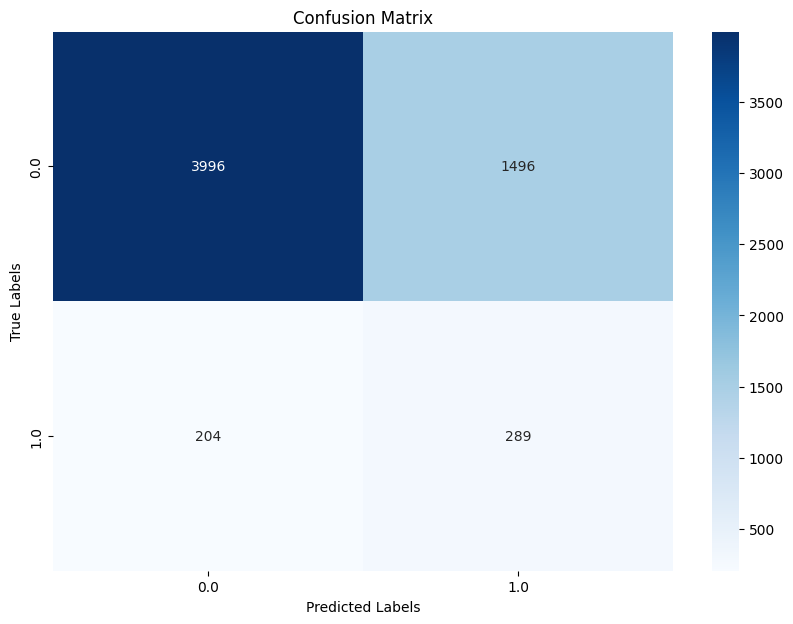

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Plot the Confusion Matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_balanced), yticklabels=np.unique(y_balanced))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [22]:
svm_model

SVC(random_state=42)

In [23]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(svm_model, X_test_processed.toarray(), y_test, n_repeats=30, random_state=42)


                             Feature  Importance
0                       num__ranking    0.032609
10             cat__KMeans_Cluster_0    0.012615
12             cat__KMeans_Cluster_2    0.012314
8   cat__position_group_running_back    0.009295
13             cat__KMeans_Cluster_3    0.008800
7             cat__position_group_qb    0.005492
4     cat__position_group_linebacker    0.004439
3         cat__position_group_d_line    0.003776
5         cat__position_group_o_line    0.001220
9        cat__position_group_special    0.000256
2    cat__position_group_d_backfield    0.000162
6   cat__position_group_pass_catcher   -0.002128
1        cat__position_group_athlete   -0.003854
11             cat__KMeans_Cluster_1   -0.012788


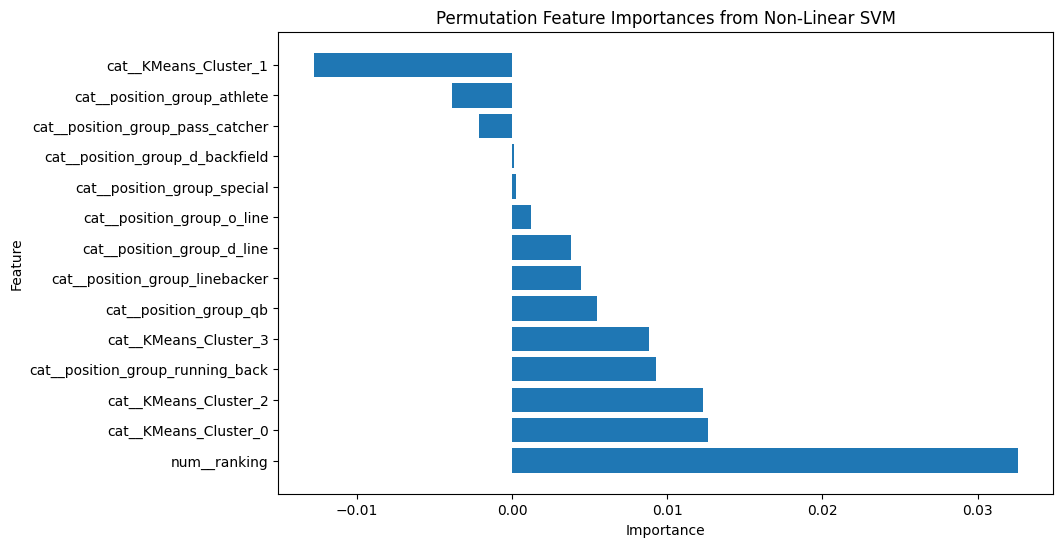

In [24]:

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': preprocessor.get_feature_names_out(), 'Importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importances from Non-Linear SVM')
plt.show()